In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-multi-head
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14993 sha256=a31b62f77aa3bda7ecee51b3da373621b4ab1eb5058487893b9f0f4fdee9ea82
  Stored in directory: /root/.cache/pip/wheels/86/aa/3c/9d15d24005179dae08ff291ce99c754b296347817d076fd9fb
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=080ad878d859d7eae9cd9579000842fbb9cbffe67476f508df461c61444a228d
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-multi-head keras-self-attention
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install --upgrade keras
#!pip install --upgrade tensorflow

In [3]:
import keras 
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

In [ ]:
!pip list


In [4]:
import numpy as np
import os
import sys

import wave
import copy
import math
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Bidirectional, Conv1D
from keras.layers.wrappers import TimeDistributed
#from keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.layers import add
from keras_multi_head import MultiHead


In [ ]:
%cd /content/drive/MyDrive/PROJECT/codes

In [6]:
from features import *
from helper import *

In [7]:

#code_path = os.path.dirname(os.path.realpath(os.getcwd()))
code_path = "/content/drive/MyDrive/PROJECT/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000


In [8]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [9]:
def calculate_features(frames, freq, options):
    window_sec = 0.2
    window_n = int(freq * window_sec)

    st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)

    if st_f.shape[1] > 2:
        i0 = 1
        i1 = st_f.shape[1] - 1
        if i1 - i0 < 1:
            i1 = i0 + 1
        
        deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
        for i in range(i0, i1):
            i_left = i - 1
            i_right = i + 1
            deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
        return deriv_st_f
    elif st_f.shape[1] == 2:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f
    else:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f

In [10]:
x_train_speech = []

counter = 0
for ses_mod in data2:
    x_head = ses_mod['signal']
    st_features = calculate_features(x_head, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    x_train_speech.append( st_features.T )
    counter+=1
    if(counter%100==0):
        print(counter)
    
x_train_speech = np.array(x_train_speech)
x_train_speech.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


(4936, 100, 34)

In [ ]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)
Y = np.array(Y)
# Y.shape
print(len(Y))

In [22]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [23]:
xtrain_sp = x_train_speech[:3838]
xtest_sp = x_train_speech[3838:]
ytrain_sp = Y[:3838]
ytest_sp = Y[3838:]

print(xtrain_sp.shape)
print(xtest_sp.shape)

print(ytrain_sp.shape)
print(xtest_sp.shape)


(3838, 100, 34)
(1098, 100, 34)
(3838,)
(1098, 100, 34)


# **MODEL 1**

In [24]:
def gru_model1(optimizer='Adam'):
    model1 = Sequential()
    
    model1.add(GRU(128, return_sequences=True, input_shape=(100, 34)))
    model1.add(GRU(128, return_sequences=True))
    model1.add(GRU(128, return_sequences=False))
    
    model1.add(Dense(256))
    model1.add(Activation('relu'))
    model1.add(Dense(4))
    model1.add(Activation('softmax'))

    model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model1

In [25]:
model1 = gru_model1()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 128)          62976     
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          99072     
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
 activation_3 (Activation)   (None, 4)                

In [ ]:
hist = model1.fit(xtrain_sp, ytrain_sp, 
                 batch_size=100, epochs=2, verbose=1, shuffle = True, 
                 validation_data=(xtest_sp, ytest_sp))

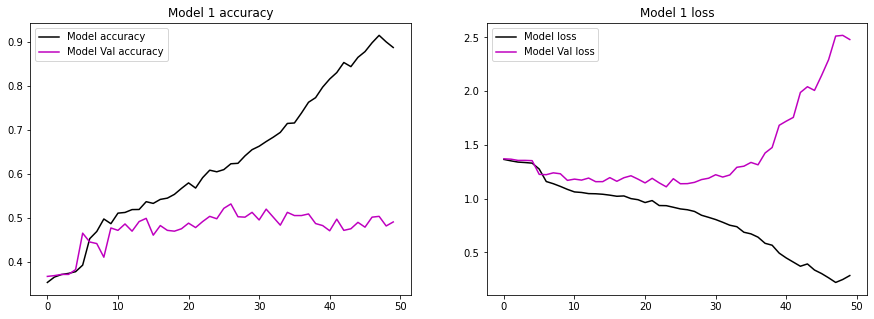

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model1.evaluate(xtrain_sp, ytrain_sp,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model1.evaluate(xtest_sp, ytest_sp,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.20270 dan Training Accuracy 92.63%
Validation Loss 2.48014 dan Validation Accuracy 49.09%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model1.predict(xtrain_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_sp, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.94      0.96      0.95       933
         exc       0.99      0.92      0.95       742
         neu       0.90      0.93      0.92      1324
         sad       0.93      0.85      0.89       839

   micro avg       0.93      0.92      0.92      3838
   macro avg       0.94      0.91      0.93      3838
weighted avg       0.93      0.92      0.92      3838
 samples avg       0.92      0.92      0.92      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model1.predict(xtest_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_sp, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.40      0.54      0.45       170
         exc       0.52      0.26      0.34       299
         neu       0.46      0.55      0.50       384
         sad       0.62      0.59      0.61       245

   micro avg       0.49      0.48      0.48      1098
   macro avg       0.50      0.48      0.48      1098
weighted avg       0.50      0.48      0.48      1098
 samples avg       0.48      0.48      0.48      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.54 0.1  0.27 0.09]
 [0.23 0.26 0.42 0.08]
 [0.18 0.12 0.58 0.13]
 [0.03 0.04 0.32 0.6 ]]


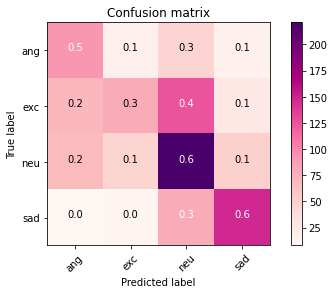

In [ ]:
import itertools
Y_pred = model1.predict(xtest_sp)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_sp,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

# **MODEL 2**

In [ ]:
def gru_model_2(optimizer='Adam'):
    model2 = Sequential()
    
    model2.add(GRU(128, return_sequences=True, input_shape=(100, 34)))
    model2.add(SeqSelfAttention(attention_activation='relu'))
    model2.add(GRU(128, return_sequences=True))
    model2.add(SeqSelfAttention(attention_activation='relu'))
    model2.add(GRU(128, return_sequences=False))
    
    #model.add(Flatten())
    model2.add(Dense(256))
    model2.add(Activation('relu'))
    model2.add(Dense(4))
    model2.add(Activation('softmax'))

    model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model2

In [ ]:
model2 = gru_model_2()
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 100, 128)          62976     
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 128)         8257      
_________________________________________________________________
gru_10 (GRU)                 (None, None, 128)         99072     
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 128)         8257      
_________________________________________________________________
gru_11 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_6 (Activation)    (None, 256)              

In [ ]:
hist = model2.fit(xtrain_sp, ytrain_sp, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_sp, ytest_sp))

Epoch 1/50
39/39 [==============================] - 7s 62ms/step - loss: 1.3347 - accuracy: 0.3557 - val_loss: 1.2823 - val_accuracy: 0.4526
Epoch 2/50
39/39 [==============================] - 2s 39ms/step - loss: 1.1537 - accuracy: 0.4687 - val_loss: 1.1341 - val_accuracy: 0.4964
Epoch 3/50
39/39 [==============================] - 2s 39ms/step - loss: 1.1024 - accuracy: 0.4862 - val_loss: 1.1708 - val_accuracy: 0.4991
Epoch 4/50
39/39 [==============================] - 2s 39ms/step - loss: 1.0994 - accuracy: 0.4888 - val_loss: 1.1693 - val_accuracy: 0.4763
Epoch 5/50
39/39 [==============================] - 2s 39ms/step - loss: 1.0736 - accuracy: 0.5040 - val_loss: 1.1251 - val_accuracy: 0.4818
Epoch 6/50
39/39 [==============================] - 2s 39ms/step - loss: 1.0433 - accuracy: 0.5229 - val_loss: 1.2082 - val_accuracy: 0.4353
Epoch 7/50
39/39 [==============================] - 2s 39ms/step - loss: 1.0346 - accuracy: 0.5156 - val_loss: 1.2870 - val_accuracy: 0.4554
Epoch 8/50
39

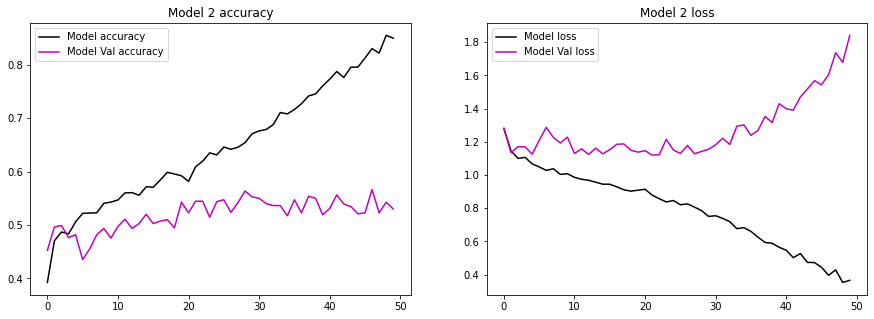

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 2 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 2 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model2.evaluate(xtrain_sp, ytrain_sp,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model2.evaluate(xtest_sp, ytest_sp,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.36791 and Training Accuracy 85.12%
Validation Loss 1.84051 and Validation Accuracy 53.01%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 2")
pred = model2.predict(xtrain_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_sp, labels, target_names = emotions_used))

model 2
              precision    recall  f1-score   support

         ang       0.90      0.86      0.88       933
         exc       0.90      0.80      0.85       742
         neu       0.85      0.80      0.82      1324
         sad       0.85      0.84      0.84       839

   micro avg       0.87      0.82      0.85      3838
   macro avg       0.87      0.83      0.85      3838
weighted avg       0.87      0.82      0.85      3838
 samples avg       0.82      0.82      0.82      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 2")
pred = model2.predict(xtest_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_sp, labels, target_names = emotions_used))

model 2
              precision    recall  f1-score   support

         ang       0.48      0.55      0.52       170
         exc       0.55      0.38      0.45       299
         neu       0.53      0.49      0.51       384
         sad       0.62      0.62      0.62       245

   micro avg       0.55      0.50      0.52      1098
   macro avg       0.55      0.51      0.52      1098
weighted avg       0.55      0.50      0.52      1098
 samples avg       0.50      0.50      0.50      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 2
Normalized Confusion Matrix
[[0.55 0.12 0.25 0.08]
 [0.18 0.4  0.35 0.07]
 [0.13 0.16 0.54 0.17]
 [0.04 0.1  0.2  0.66]]


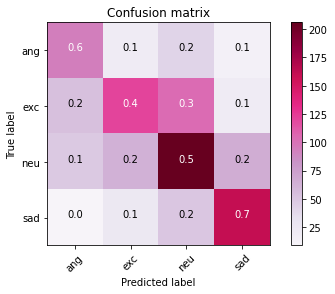

In [ ]:
import itertools
Y_pred = model2.predict(xtest_sp)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_sp,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 2")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL 3**

In [ ]:
def gru_model_3(optimizer='Adam'):
    model3 = Sequential()
    
    model3.add(Bidirectional(GRU(128, activation="relu", return_sequences=True), input_shape=(100, 34)))
    model3.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
    model3.add(Bidirectional(GRU(128)))


    #model.add(Flatten())
    model3.add(Dense(256))
    model3.add(Activation('relu'))
    model3.add(Dense(4))
    model3.add(Activation('softmax'))

    model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model3

In [ ]:
model3 = gru_model_3()
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100, 256)          125952    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 256)          296448    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1028      
_________________________________________________________________
activation_11 (Activation)   (None, 4)                

In [ ]:
hist = model3.fit(xtrain_sp, ytrain_sp, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_sp, ytest_sp))

Epoch 1/50
39/39 [==============================] - 32s 675ms/step - loss: 1.3643 - accuracy: 0.3435 - val_loss: 1.2245 - val_accuracy: 0.4709
Epoch 2/50
39/39 [==============================] - 25s 651ms/step - loss: 1.1406 - accuracy: 0.4665 - val_loss: 1.1739 - val_accuracy: 0.4763
Epoch 3/50
39/39 [==============================] - 26s 656ms/step - loss: 1.1336 - accuracy: 0.4758 - val_loss: 1.1795 - val_accuracy: 0.4426
Epoch 4/50
39/39 [==============================] - 26s 655ms/step - loss: 1.0868 - accuracy: 0.4989 - val_loss: 1.1826 - val_accuracy: 0.4572
Epoch 5/50
39/39 [==============================] - 25s 642ms/step - loss: 1.0856 - accuracy: 0.4906 - val_loss: 1.1528 - val_accuracy: 0.4872
Epoch 6/50
39/39 [==============================] - 25s 634ms/step - loss: 1.0896 - accuracy: 0.4960 - val_loss: 1.2093 - val_accuracy: 0.4754
Epoch 7/50
39/39 [==============================] - 25s 643ms/step - loss: 1.0580 - accuracy: 0.5161 - val_loss: 1.1103 - val_accuracy: 0.4927

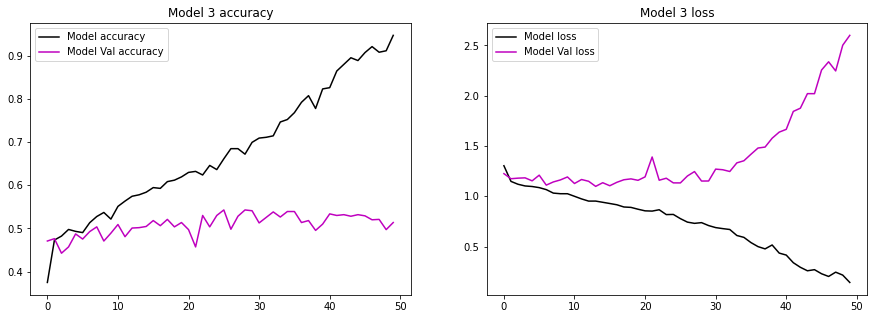

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 3 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 3 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model3.evaluate(xtrain_sp, ytrain_sp,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model3.evaluate(xtest_sp, ytest_sp,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.11522 and Training Accuracy 95.39%
Validation Loss 2.59922 and Validation Accuracy 51.37%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 3")
pred = model3.predict(xtrain_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_sp, labels, target_names = emotions_used))

model 3
              precision    recall  f1-score   support

         ang       0.99      0.98      0.98       933
         exc       1.00      0.95      0.97       742
         neu       0.96      0.92      0.94      1324
         sad       0.90      0.97      0.93       839

   micro avg       0.96      0.95      0.95      3838
   macro avg       0.96      0.96      0.96      3838
weighted avg       0.96      0.95      0.95      3838
 samples avg       0.95      0.95      0.95      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 3")
pred = model3.predict(xtest_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_sp, labels, target_names = emotions_used))

model 3
              precision    recall  f1-score   support

         ang       0.42      0.48      0.45       170
         exc       0.53      0.31      0.39       299
         neu       0.50      0.53      0.52       384
         sad       0.58      0.72      0.65       245

   micro avg       0.51      0.51      0.51      1098
   macro avg       0.51      0.51      0.50      1098
weighted avg       0.51      0.51      0.50      1098
 samples avg       0.51      0.51      0.51      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 3
Normalized Confusion Matrix
[[0.49 0.18 0.23 0.11]
 [0.18 0.32 0.38 0.11]
 [0.15 0.11 0.54 0.2 ]
 [0.02 0.05 0.2  0.72]]


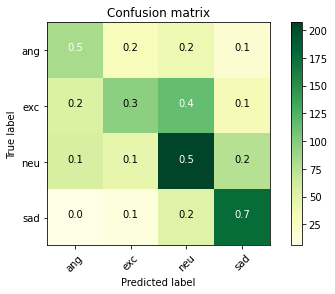

In [ ]:
import itertools
Y_pred = model3.predict(xtest_sp)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_sp,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 3")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL 4**

In [ ]:
def gru_model_4(optimizer='Adam'):
    model4 = Sequential()
    
    model4.add(Bidirectional(GRU(128, activation="relu", return_sequences=True), input_shape=(100, 34)))
    model4.add(SeqSelfAttention(attention_activation="relu"))
    model4.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
    model4.add(SeqSelfAttention(attention_activation="relu"))
    model4.add(Bidirectional(GRU(128, activation='relu')))
    model4.add(Dropout(0.1))

    model4.add(Dense(256))
    model4.add(Activation('relu'))
    model4.add(Dense(4))
    model4.add(Activation('softmax'))

    model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    #print(model.summary())

    return model4

In [ ]:
model4 = gru_model_4()
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 100, 256)          125952    
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 256)         296448    
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [ ]:
hist = model4.fit(xtrain_sp, ytrain_sp, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_sp, ytest_sp))

Epoch 1/50
39/39 [==============================] - 44s 989ms/step - loss: 1.3812 - accuracy: 0.3238 - val_loss: 1.2754 - val_accuracy: 0.4053
Epoch 2/50
39/39 [==============================] - 37s 940ms/step - loss: 1.2135 - accuracy: 0.4297 - val_loss: 1.2281 - val_accuracy: 0.4271
Epoch 3/50
39/39 [==============================] - 37s 951ms/step - loss: 1.1491 - accuracy: 0.4625 - val_loss: 1.1526 - val_accuracy: 0.4745
Epoch 4/50
39/39 [==============================] - 37s 940ms/step - loss: 1.0916 - accuracy: 0.4959 - val_loss: 1.1613 - val_accuracy: 0.4608
Epoch 5/50
39/39 [==============================] - 37s 951ms/step - loss: 1.1042 - accuracy: 0.4914 - val_loss: 1.1811 - val_accuracy: 0.4672
Epoch 6/50
39/39 [==============================] - 38s 968ms/step - loss: 1.0668 - accuracy: 0.5152 - val_loss: 1.2716 - val_accuracy: 0.4126
Epoch 7/50
39/39 [==============================] - 37s 951ms/step - loss: 1.0948 - accuracy: 0.4906 - val_loss: 1.1082 - val_accuracy: 0.5027

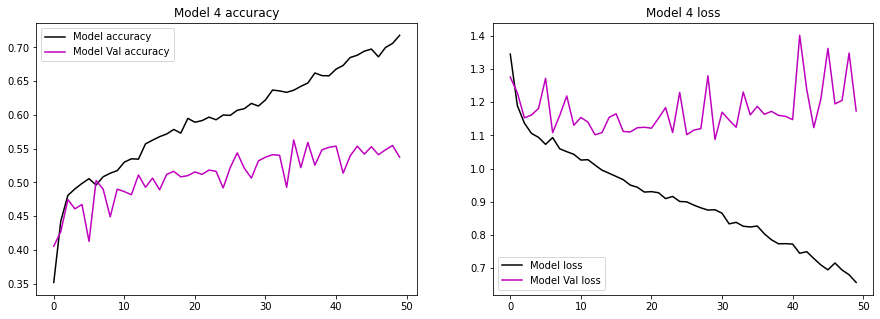

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 4 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 4 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model4.evaluate(xtrain_sp, ytrain_sp,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model4.evaluate(xtest_sp, ytest_sp,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.66503 and Training Accuracy 72.09%
Validation Loss 1.17326 and Validation Accuracy 53.73%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 4")
pred = model4.predict(xtrain_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_sp, labels, target_names = emotions_used))

model 4
              precision    recall  f1-score   support

         ang       0.73      0.75      0.74       933
         exc       0.90      0.57      0.70       742
         neu       0.81      0.45      0.58      1324
         sad       0.83      0.70      0.76       839

   micro avg       0.80      0.60      0.69      3838
   macro avg       0.82      0.62      0.69      3838
weighted avg       0.81      0.60      0.68      3838
 samples avg       0.60      0.60      0.60      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 4")
pred = model4.predict(xtest_sp)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_sp, labels, target_names = emotions_used))

model 4
              precision    recall  f1-score   support

         ang       0.46      0.56      0.51       170
         exc       0.60      0.22      0.33       299
         neu       0.61      0.39      0.47       384
         sad       0.71      0.61      0.65       245

   micro avg       0.59      0.42      0.49      1098
   macro avg       0.59      0.44      0.49      1098
weighted avg       0.60      0.42      0.48      1098
 samples avg       0.42      0.42      0.42      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrBr):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 4
Normalized Confusion Matrix
[[0.61 0.13 0.22 0.04]
 [0.26 0.32 0.33 0.08]
 [0.17 0.09 0.6  0.14]
 [0.05 0.08 0.21 0.66]]


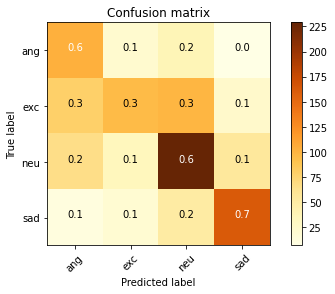

In [ ]:
import itertools
Y_pred = model4.predict(xtest_sp)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_sp,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 4")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 